# Complete RaTag Analysis Pipeline - OPTIMIZED VERSION

This notebook demonstrates the **optimized unified pipeline** with ~50% time savings.

## Key Improvements

1. **Unified Integration**: X-ray classification + S2 integration in SINGLE pass (2 hours instead of 4)
2. **Fast S2 Window Estimation**: Uses only 2k waveforms instead of all 100k (~5 min instead of 30 min)
3. **Same Output**: Identical results to original pipeline, fully compatible

## Workflow

1. **Prepare Run**: Load data, estimate S1 times, compute fields (with fast S2 window estimation)
2. **Unified Integration**: X-ray classification + S2 integration in one pass ⚡
3. **S2 Fitting**: Fast post-processing (no waveform loading)
4. **Calibration**: Energy calibration and recombination analysis

**Total Time**: ~2.1 hours (vs ~4.5 hours for separate workflows)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from RaTag.datatypes import Run
from RaTag.config import IntegrationConfig, FitConfig
from RaTag.pipeline_optimized import (
    prepare_run_optimized,
    run_unified_integration,
    run_s2_fitting,
    run_calibration_analysis_optimized
)
import RaTag.plotting as plotting

%matplotlib inline

## 1. Define Run Parameters

In [3]:
# Set data directory
base_dir = Path('/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec')

# Define run parameters
run8 = Run(
    root_directory = base_dir,
    run_id = "RUN8",
    el_field = 2375,            # V/cm
    target_isotope = "Th228",
    pressure = 2.0,             # bar
    temperature = 297,          # K
    sampling_rate = 5e9,        # Hz (5 GS/s for FastFrame)
    el_gap = 0.8,               # cm
    drift_gap = 1.4,            # cm
    width_s2 = 20,              # µs
    
    # Calibration constants
    W_value = 22.0,             # eV per e-ion pair (Xe @ 2 bar)
    E_gamma_xray = 12.3e3,      # eV (Th-228 X-ray energy)
)

## 2. Prepare Run (OPTIMIZED)

**Key optimization**: S2 window estimation uses only **500 waveforms** instead of all ~100k

This step:
- Computes gas density from pressure/temperature
- Loads all measurement sets from directory structure
- Estimates S1 time for each set
- **Estimates S2 timing windows from 500 waveforms per set** (fast!)
- Computes drift/EL fields and transport properties

**Time**: ~1 minutes (vs ~30 minutes in old pipeline)

In [4]:
from RaTag.constructors import populate_run


run8 = populate_run(run8)

  Loaded: FieldScan_Gate050_Anode1950 - 2030 files (97440 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate100_Anode2000 - 2015 files (96720 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate200_Anode2100 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate300_Anode2200 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate400_Anode2300 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate500_Anode2400 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate600_Anode2500 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]


In [13]:
# Prepare run with optimized S2 window estimation
run8 = prepare_run_optimized(
    run8,
    flag_plot=False,
    max_frames_s1=200,         # Only 200 frames needed for S1 estimation
    estimate_s2_windows=True,
    max_frames_s2=500,        # Only 500 frames needed for S2 window estimation
    s2_duration_cuts=(5, 25),
    threshold_s2=0.8
)

PREPARING RUN (OPTIMIZED): RUN8

[1/4] Gas density: 4.877e+19 cm⁻³
  Loaded: FieldScan_Gate050_Anode1950 - 2030 files (97440 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate100_Anode2000 - 2015 files (96720 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate200_Anode2100 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate300_Anode2200 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate400_Anode2300 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate500_Anode2400 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate600_Anode2500 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]

[2/4] Loaded 7 sets (all files)

[3/4] Preparing sets (using 200 files for S1 estimation)...
  → Processing set 1/7: FieldScan_Gate050_Anode1950
  S1 estimation: processing 5 files (~240 frames)
  → t_s1 = -3.345 ± 1.5 µs (from 126 frames)
  → Pr

In [20]:
run8.sets[0].metadata

{'anode': 1950,
 'gate': 50,
 't_s1': np.float64(-3.345),
 't_s1_std': np.float64(1.5),
 't_s2_start_mean': np.float64(16.721200000000007),
 't_s2_start_std': np.float64(2.7670800000000026),
 't_s2_end_mean': np.float64(28.164200000000005),
 't_s2_end_std': np.float64(3.5292119999999993),
 's2_duration_mean': np.float64(12.2872),
 's2_duration_std': np.float64(4.384499999999997)}

In [15]:
# Inspect prepared sets
print(f"Prepared {len(run8.sets)} sets:\n")
for i, s in enumerate(run8.sets):
    print(f"Set {i+1}: {s.source_dir.name}")
    print(f"  t_s1: ({s.metadata['t_s1']:.3f} ± {s.metadata['t_s1_std']:.3f}) µs")
    print(f"  Drift field: {s.drift_field:.1f} V/cm")
    print(f"  Drift time: {s.time_drift:.3f} µs")
    
    # Show S2 window if estimated
    if 't_s2_start_mean' in s.metadata:
        print(f"  S2 window: [{s.metadata['t_s2_start_mean']:.2f}, {s.metadata['t_s2_end_mean']:.2f}] µs")
        print(f"  S2 duration: {s.metadata['s2_duration_mean']:.2f} ± {s.metadata['s2_duration_std']:.2f} µs")
    print()

Prepared 7 sets:

Set 1: FieldScan_Gate050_Anode1950
  t_s1: (-3.345 ± 1.500) µs
  Drift field: 35.7 V/cm
  Drift time: 19.976 µs
  S2 window: [16.72, 28.16] µs
  S2 duration: 12.29 ± 4.38 µs

Set 2: FieldScan_Gate100_Anode2000
  t_s1: (-3.250 ± 1.414) µs
  Drift field: 71.4 V/cm
  Drift time: 15.138 µs
  S2 window: [12.25, 16.78] µs
  S2 duration: 6.96 ± 3.59 µs

Set 3: FieldScan_Gate200_Anode2100
  t_s1: (-3.269 ± 1.128) µs
  Drift field: 142.9 V/cm
  Drift time: 13.210 µs
  S2 window: [11.40, 15.08] µs
  S2 duration: 7.98 ± 6.47 µs

Set 4: FieldScan_Gate300_Anode2200
  t_s1: (-3.319 ± 1.678) µs
  Drift field: 214.3 V/cm
  Drift time: 12.431 µs
  S2 window: [11.07, 14.57] µs
  S2 duration: 8.60 ± 6.56 µs

Set 5: FieldScan_Gate400_Anode2300
  t_s1: (-3.416 ± 2.028) µs
  Drift field: 285.7 V/cm
  Drift time: 11.835 µs
  S2 window: [10.59, 13.96] µs
  S2 duration: 8.84 ± 6.88 µs

Set 6: FieldScan_Gate500_Anode2400
  t_s1: (-3.343 ± 1.463) µs
  Drift field: 357.1 V/cm
  Drift time: 11.33

### Optional: Manual Adjustment of S1 Times

If automatic S1 estimation is off for some sets, adjust manually:

In [ ]:
# Example: adjust S1 time for specific sets if needed
# from dataclasses import replace
# run8.sets[0] = replace(run8.sets[0], metadata={**run8.sets[0].metadata, 't_s1': -3.32})
# run8.sets[2] = replace(run8.sets[2], metadata={**run8.sets[2].metadata, 't_s1': -3.32})

### Visualize S2 Windows

Check that S2 integration windows are correctly positioned:

Averaging FastFrame waveform for plotting
y_max: 7.80 V
Averaging FastFrame waveform for plotting
y_max: 33.00 V
Averaging FastFrame waveform for plotting
y_max: 50.20 V
Averaging FastFrame waveform for plotting
y_max: 90.60 V
Averaging FastFrame waveform for plotting
y_max: 66.60 V
Averaging FastFrame waveform for plotting
y_max: 65.00 V
Averaging FastFrame waveform for plotting
y_max: 90.60 V


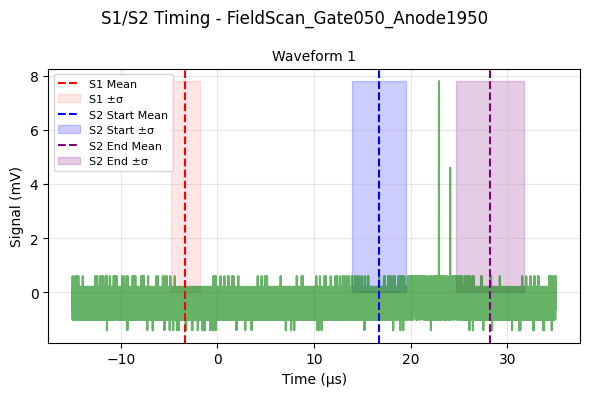

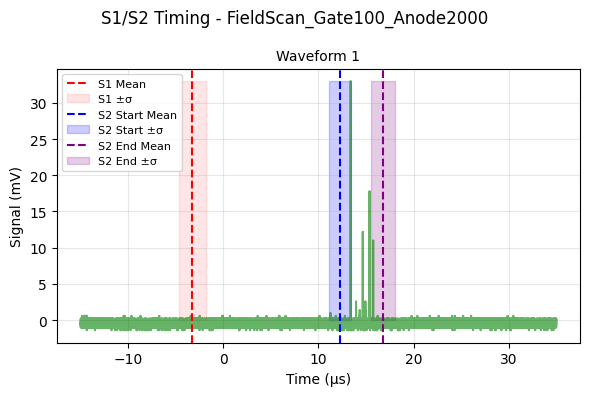

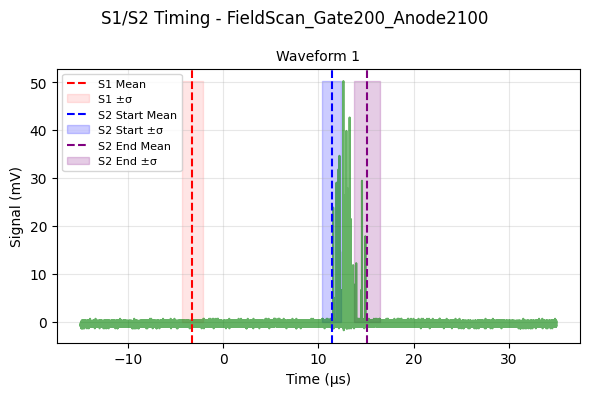

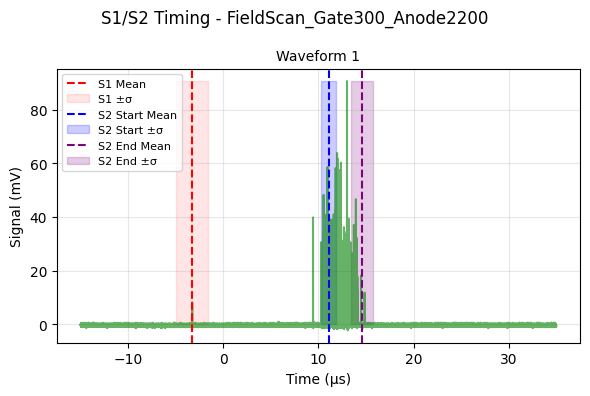

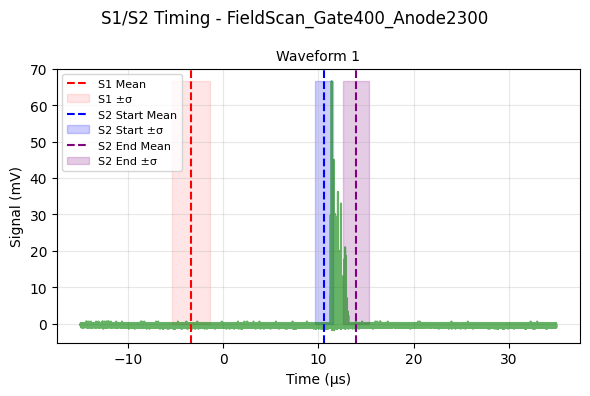

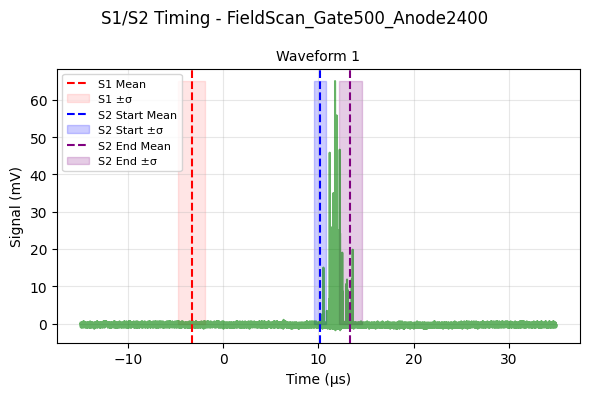

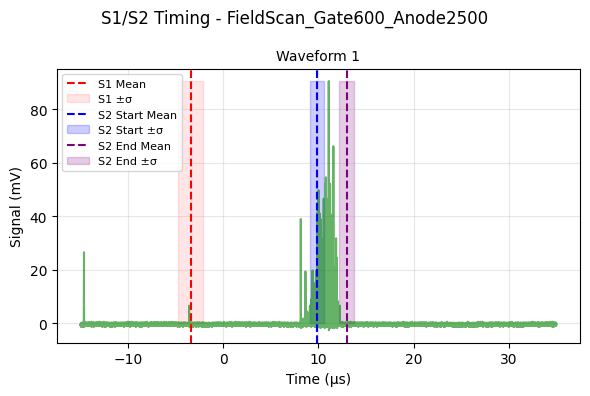

In [21]:
# Plot S2 windows for visual verification
for s in run8.sets:
    plotting.plot_waveforms_with_s1_s2(s, n_waveforms=1)

## 3. Unified Integration (MAJOR OPTIMIZATION)

**This is the key optimization!** 

Instead of running X-ray classification and S2 integration separately (each taking ~2 hours), we process both **in a single pass** over all waveforms.

**What happens here**:
1. Load each waveform once
2. Preprocess once (unit conversion, pedestal subtraction, moving average, threshold clip)
3. Extract X-ray window → classify
4. Extract S2 window → integrate
5. Save both results

**Time**: ~2 hours (vs ~4 hours for separate workflows)  
**Speedup**: 2× faster!

### Testing Mode

For quick testing, uncomment the `nfiles=10` parameter below to process only 20 files per set (~1 minutes total).

In [22]:
# Define integration configurations
xray_config = IntegrationConfig(
    bs_threshold = 0.5,        # mV
    n_pedestal = 200,          # samples
    ma_window = 10,            # samples
    dt = 2e-4,                 # µs
)

ion_config = IntegrationConfig(
    bs_threshold = 0.8,        # mV
    n_pedestal = 2000,         # samples
    ma_window = 9,             # samples
    dt = 2e-4,                 # µs
)

In [ ]:
# UNIFIED INTEGRATION: X-ray classification + S2 integration in SINGLE PASS
xray_results, s2_areas = run_unified_integration(
    run8,
    ts2_tol=-2.7,
    xray_config=xray_config,
    ion_config=ion_config,
    use_estimated_s2_windows=True,
    max_frames=None  # Set to 10 for testing, None for full run
)

print("\n✓ Unified integration complete!")
print(f"✓ Processed {len(s2_areas)} sets in SINGLE pass")
print("✓ X-ray results saved: xray_results.json, xray_areas.npy")
print("✓ S2 results saved: s2_areas.npy, s2_results.json")

⚠ TEST MODE: limiting to 200 files per set
   For production, run without nfiles parameter to process all files

UNIFIED INTEGRATION: X-RAY CLASSIFICATION + S2 AREAS
Processing 7 sets with SINGLE pass over waveforms

[1/7] Processing: FieldScan_Gate050_Anode1950
  → Using tS1: [-3.35 ± 1.50] µs
  → Using estimated S2 window: [16.72, 28.16] µs
  → X-rays: 1452/9600 accepted (15.1%)
  → S2 areas: 9600 integrated
  → Saved: xray_results.json, xray_areas.npy, s2_areas.npy, s2_results.json

[2/7] Processing: FieldScan_Gate100_Anode2000
  → Using tS1: [-3.25 ± 1.41] µs
  → Using estimated S2 window: [12.25, 16.78] µs
  → X-rays: 1105/9600 accepted (11.5%)
  → S2 areas: 9600 integrated
  → Saved: xray_results.json, xray_areas.npy, s2_areas.npy, s2_results.json

[3/7] Processing: FieldScan_Gate200_Anode2100
  → Using tS1: [-3.27 ± 1.13] µs
  → Using estimated S2 window: [11.40, 15.08] µs
  → X-rays: 917/9600 accepted (9.6%)
  → S2 areas: 9600 integrated
  → Saved: xray_results.json, xray_areas

In [40]:
from RaTag.dataIO import store_xrayset
store_xrayset(xray_results['FieldScan_Gate050_Anode1950'], run8.sets[0].source_dir)

### Check Results

Verify that both X-ray and S2 data were collected:

In [25]:
# Check X-ray classification results
print("X-ray Classification Summary:\n")
for set_name, xray_result in xray_results.items():
    n_accepted = sum(1 for e in xray_result.events if e.accepted)
    n_total = len(xray_result.events)
    print(f"{set_name}:")
    print(f"  {n_accepted}/{n_total} events accepted ({100*n_accepted/n_total:.1f}%)")

X-ray Classification Summary:

FieldScan_Gate050_Anode1950:
  1452/9600 events accepted (15.1%)
FieldScan_Gate100_Anode2000:
  1105/9600 events accepted (11.5%)
FieldScan_Gate200_Anode2100:
  917/9600 events accepted (9.6%)
FieldScan_Gate300_Anode2200:
  1178/9600 events accepted (12.3%)
FieldScan_Gate400_Anode2300:
  993/9600 events accepted (10.3%)
FieldScan_Gate500_Anode2400:
  1080/9600 events accepted (11.2%)
FieldScan_Gate600_Anode2500:
  906/9600 events accepted (9.4%)


In [26]:
# Check S2 integration results
print("\nS2 Integration Summary:\n")
for set_name, s2_result in s2_areas.items():
    n_areas = len(s2_result.areas)
    valid_areas = s2_result.areas[~np.isnan(s2_result.areas)]
    print(f"{set_name}:")
    print(f"  {len(valid_areas)}/{n_areas} valid S2 areas")
    print(f"  Mean: {np.mean(valid_areas):.3f} mV·µs")
    print(f"  Std: {np.std(valid_areas):.3f} mV·µs")


S2 Integration Summary:

FieldScan_Gate050_Anode1950:
  9600/9600 valid S2 areas
  Mean: 9.590 mV·µs
  Std: 58.819 mV·µs
FieldScan_Gate100_Anode2000:
  9600/9600 valid S2 areas
  Mean: 7.987 mV·µs
  Std: 39.984 mV·µs
FieldScan_Gate200_Anode2100:
  9600/9600 valid S2 areas
  Mean: 8.530 mV·µs
  Std: 37.366 mV·µs
FieldScan_Gate300_Anode2200:
  9600/9600 valid S2 areas
  Mean: 8.051 mV·µs
  Std: 34.900 mV·µs
FieldScan_Gate400_Anode2300:
  9600/9600 valid S2 areas
  Mean: 7.430 mV·µs
  Std: 31.894 mV·µs
FieldScan_Gate500_Anode2400:
  9600/9600 valid S2 areas
  Mean: 7.008 mV·µs
  Std: 29.071 mV·µs
FieldScan_Gate600_Anode2500:
  9600/9600 valid S2 areas
  Mean: 7.862 mV·µs
  Std: 30.670 mV·µs


## 4. S2 Fitting (Fast Post-Processing)

Fit Gaussian distributions to the S2 area histograms.

**This is fast** (~1 minute) because it only fits already-integrated data, no waveform loading.

In [27]:
# Define fitting configuration
fit_config = FitConfig(
    bin_cuts = (0, 10),        # mV·µs
    nbins = 100,
    exclude_index = 2,         # Skip first 2 bins (pedestal)
)

In [29]:
# Fit S2 distributions
s2_fitted = run_s2_fitting(
    run8,
    s2_areas,
    fit_config=fit_config,
    flag_plot=False,      # Set to True to display plots interactively
    save_plots=True       # Save plots to disk
)

print("\n✓ S2 fitting complete!")
print("✓ Plots saved to plots/ directory")

FITTING S2 DISTRIBUTIONS

Generating and saving plots...
  → Saved: /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/plots/FieldScan_Gate050_Anode1950_s2_histogram.png
Averaging FastFrame waveform for plotting
y_max: 7.80 V
Averaging FastFrame waveform for plotting
y_max: 36.60 V
Averaging FastFrame waveform for plotting
y_max: 90.60 V
Averaging FastFrame waveform for plotting
y_max: 36.20 V
Averaging FastFrame waveform for plotting
y_max: 8.20 V
Averaging FastFrame waveform for plotting
y_max: 90.60 V
Averaging FastFrame waveform for plotting
y_max: 90.60 V
Averaging FastFrame waveform for plotting
y_max: 67.40 V
Averaging FastFrame waveform for plotting
y_max: 25.80 V
Averaging FastFrame waveform for plotting
y_max: 90.60 V
  → Saved: /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/plots/FieldScan_Gate050_Anode1950_waveform_validation.png
  → Saved: /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/plots/FieldScan_Gate100_Anode2000_s2_histogram.png
Averaging FastFrame waveform 

### Visualize S2 Fits

In [30]:
# Display fit results
print("S2 Gaussian Fit Results:\n")
for set_name, fit in s2_fitted.items():
    if fit.fit_success:
        print(f"{set_name}:")
        print(f"  Mean: {fit.mean:.3f} ± {fit.ci95:.3f} mV·µs")
        print(f"  Sigma: {fit.sigma:.3f} mV·µs")
    else:
        print(f"{set_name}: Fit failed")

S2 Gaussian Fit Results:

FieldScan_Gate050_Anode1950:
  Mean: -0.131 ± 0.129 mV·µs
  Sigma: 0.777 mV·µs
FieldScan_Gate100_Anode2000:
  Mean: 0.619 ± 0.038 mV·µs
  Sigma: 0.813 mV·µs
FieldScan_Gate200_Anode2100:
  Mean: 1.039 ± 0.032 mV·µs
  Sigma: 0.911 mV·µs
FieldScan_Gate300_Anode2200:
  Mean: 1.273 ± 0.034 mV·µs
  Sigma: 1.059 mV·µs
FieldScan_Gate400_Anode2300:
  Mean: 1.460 ± 0.042 mV·µs
  Sigma: 1.161 mV·µs
FieldScan_Gate500_Anode2400:
  Mean: 1.603 ± 0.040 mV·µs
  Sigma: 1.209 mV·µs
FieldScan_Gate600_Anode2500:
  Mean: 1.739 ± 0.043 mV·µs
  Sigma: 1.213 mV·µs


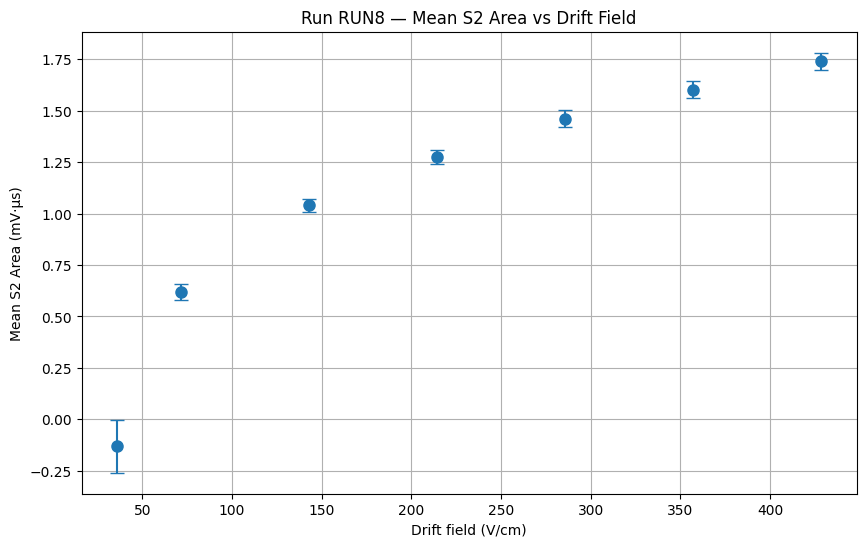

In [31]:
# Plot S2 vs drift field
fig, ax = plotting.plot_s2_vs_drift(run8, s2_fitted, normalized=False)
plt.show()

In [83]:
drift_fields = [s.drift_field for s in run8.sets]
drift_fields

[35.714285714285715,
 71.42857142857143,
 142.85714285714286,
 214.2857142857143,
 285.7142857142857,
 357.14285714285717,
 428.5714285714286]

In [81]:
max_frames = 2000
max_files_needed = int(np.ceil(max_frames / set_pmt.nframes))
print(f"  S1 estimation: processing up to {max_frames} frames (~{max_files_needed} files)")

  S1 estimation: processing up to 2000 frames (~42 files)


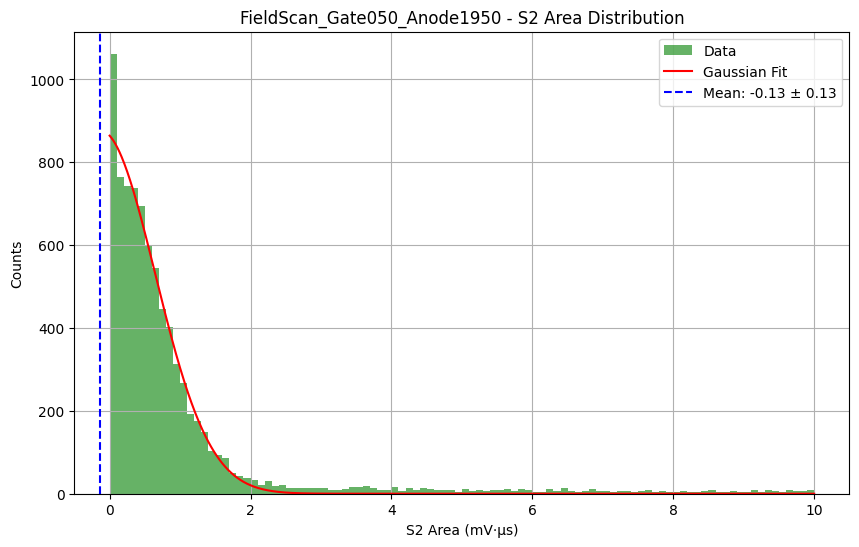

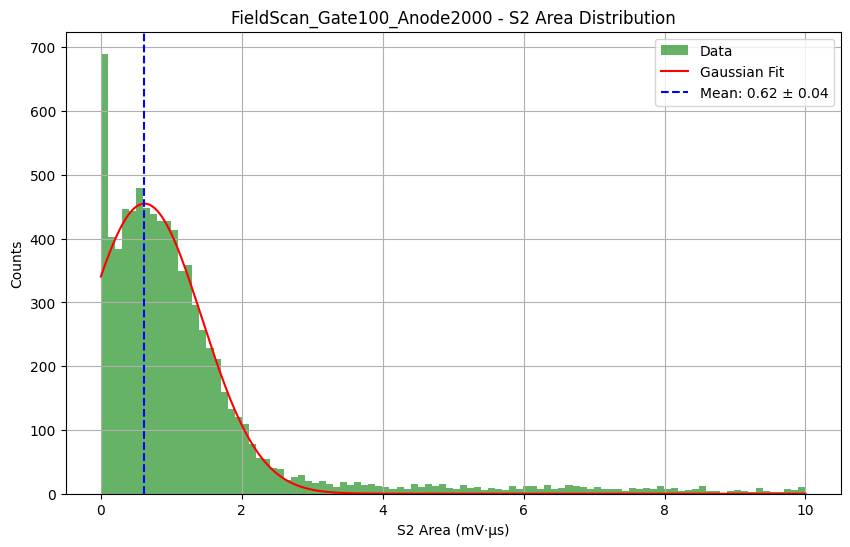

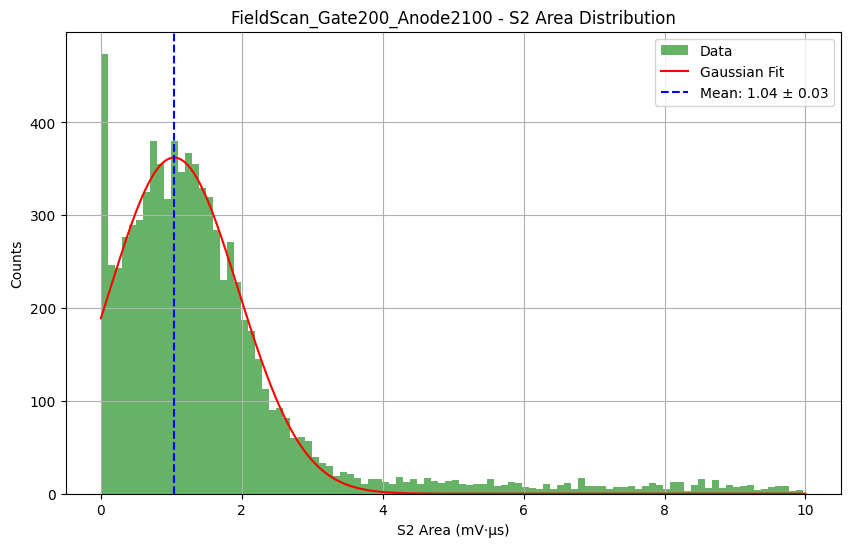

In [32]:
# Show individual histograms with fits
for set_name, fit in list(s2_fitted.items())[:3]:  # Show first 3 sets
    fig, ax = plotting.plot_hist_fit(fit, nbins=fit_config.nbins, bin_cuts=fit_config.bin_cuts)
    plt.title(f"{set_name} - S2 Area Distribution")
    plt.show()

Averaging FastFrame waveform for plotting
y_max: 33.00 V
Averaging FastFrame waveform for plotting
y_max: 15.40 V
Averaging FastFrame waveform for plotting
y_max: 31.00 V
Averaging FastFrame waveform for plotting
y_max: 90.60 V
Averaging FastFrame waveform for plotting
y_max: 28.20 V


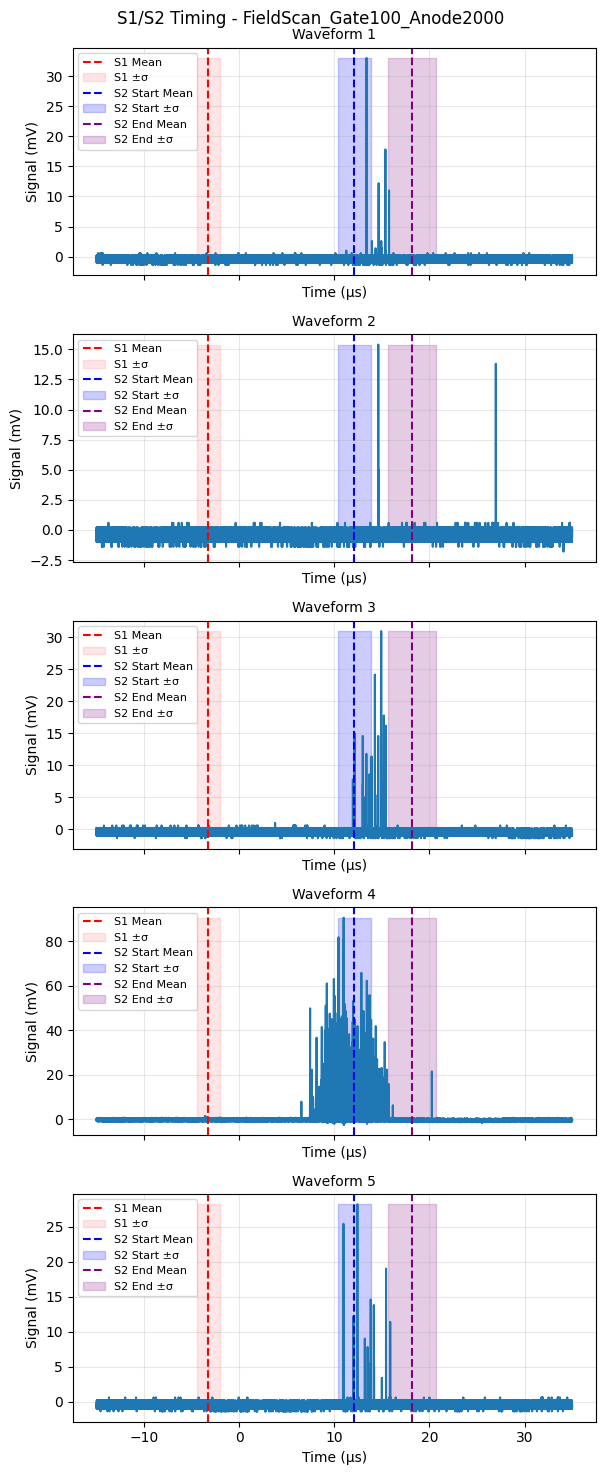

In [91]:
set_pmt = run8.sets[1]
n_waveforms=5
fig_wf, _ = plotting.plot_waveforms_with_s1_s2(
                    set_pmt,
                    n_waveforms=n_waveforms,
                    t_s1_mean=set_pmt.metadata.get("t_s1"),
                    t_s1_std=set_pmt.metadata.get("t_s1_std"),
                    t_s2_start_mean=set_pmt.metadata.get("t_s2_start_mean"),
                    t_s2_start_std=set_pmt.metadata.get("t_s2_start_std"),
                    t_s2_end_mean=set_pmt.metadata.get("t_s2_end_mean"),
                    t_s2_end_std=set_pmt.metadata.get("t_s2_end_std")/3,
                    figsize=(6, 3 * n_waveforms)
                )

## 5. Calibration and Recombination Analysis

Use X-ray data (saved during unified integration) to calibrate the energy scale and compute electron recombination fractions.

**This step loads X-ray data from disk** (saved in step 3).

**Time**: ~1 minute


CALIBRATION & RECOMBINATION ANALYSIS
Loading X-ray data from disk (saved by unified integration)...
CALIBRATION AND RECOMBINATION ANALYSIS

[1/5] Loading X-ray results...
  → FieldScan_Gate050_Anode1950: 156 accepted events
  → FieldScan_Gate100_Anode2000: 150 accepted events
  → FieldScan_Gate200_Anode2100: 110 accepted events
  → FieldScan_Gate300_Anode2200: 129 accepted events
  → FieldScan_Gate400_Anode2300: 172 accepted events
  → FieldScan_Gate500_Anode2400: 116 accepted events
  → FieldScan_Gate600_Anode2500: 122 accepted events
  → Total: 955 accepted X-ray events

[2/5] Fitting X-ray histogram...


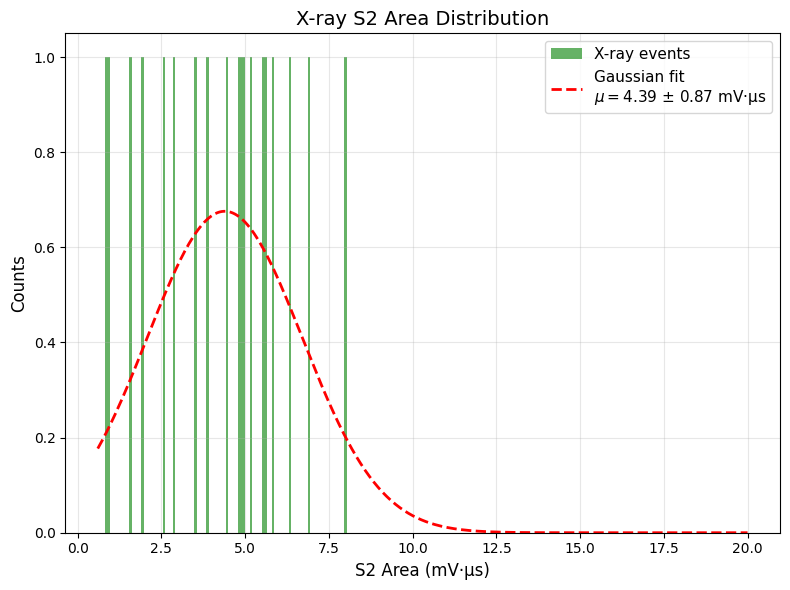

  → X-ray mean: 4.391 ± 0.865 mV·µs
  → X-ray sigma: 2.316 mV·µs
  → Saved: /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/plots/RUN8_xray_histogram.png

[3/5] Computing calibration constants...
  → Expected electrons (N_e_exp): 559.1
  → Gain factor (g_S2): 0.0079 mV·µs/electron

[4/5] Using provided ion fitted areas (7 sets)

[5/5] Computing recombination fractions...
  → Recombination fractions computed for 7 field points
  → r range: [0.604, 1.030]


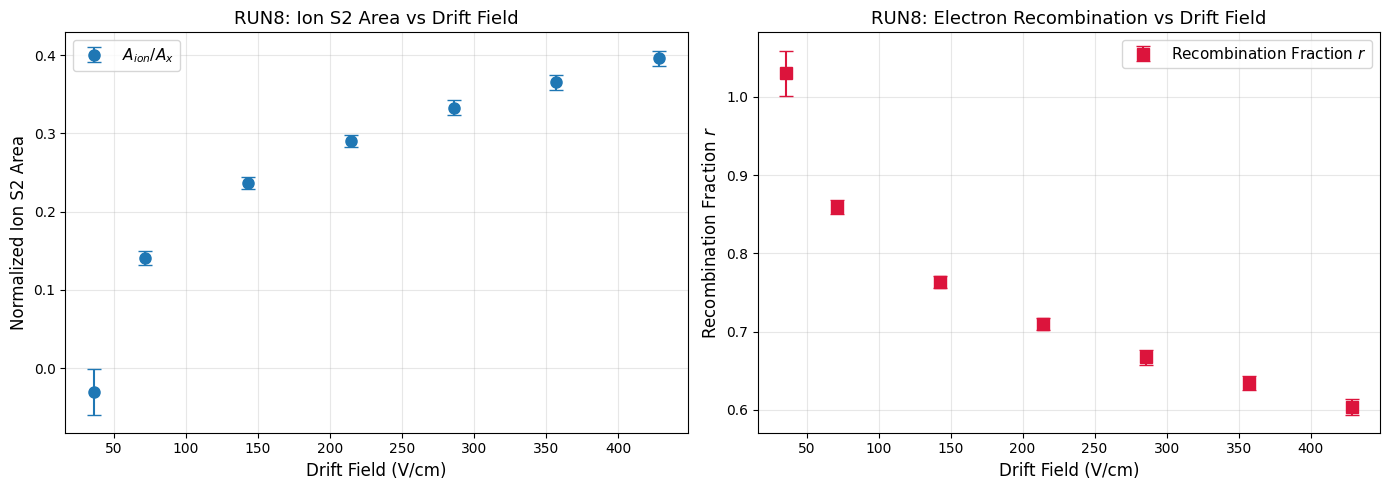


CALIBRATION COMPLETE

Generating and saving comprehensive plots...
  → S2 vs drift (normalized)...
  → Saved: /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/plots/RUN8_s2_vs_drift_normalized.png
  → Diffusion analysis...
  → Saved: /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/plots/RUN8_diffusion_analysis.png

CALIBRATION ANALYSIS COMPLETE

✓ Calibration analysis complete!
✓ All plots saved to plots/ directory


In [56]:
# Run complete calibration analysis
calib_results, recomb_results = run_calibration_analysis_optimized(
    run8,
    ion_fitted_areas=s2_fitted,
    xray_bin_cuts=(0.6, 20),
    xray_nbins=100,
    flag_plot=True,
    save_plots=True
)

print("\n✓ Calibration analysis complete!")
print("✓ All plots saved to plots/ directory")

### Display Calibration Results

In [57]:
print("=" * 60)
print("CALIBRATION CONSTANTS")
print("=" * 60)
print(f"Run: {calib_results.run_id}")
print(f"X-ray mean area (A_x): {calib_results.A_x_mean:.3f} mV·µs")
print(f"Expected electrons (N_e_exp): {calib_results.N_e_exp:.1f}")
print(f"Gain factor (g_S2): {calib_results.g_S2:.4f} mV·µs/electron")
print()

CALIBRATION CONSTANTS
Run: RUN8
X-ray mean area (A_x): 4.391 mV·µs
Expected electrons (N_e_exp): 559.1
Gain factor (g_S2): 0.0079 mV·µs/electron



In [60]:
print("=" * 60)
print("RECOMBINATION vs DRIFT FIELD")
print("=" * 60)
for i, Ed in enumerate(recomb_results['drift_fields']):
    r = recomb_results['r'][i]
    dr = recomb_results['dr'][i]
    print(f"E_d = {Ed:6.1f} V/cm → r = {r:.3f} ± {dr:.3f}")

RECOMBINATION vs DRIFT FIELD
E_d =   35.7 V/cm → r = 1.030 ± 0.029
E_d =   71.4 V/cm → r = 0.859 ± 0.009
E_d =  142.9 V/cm → r = 0.763 ± 0.007
E_d =  214.3 V/cm → r = 0.710 ± 0.008
E_d =  285.7 V/cm → r = 0.667 ± 0.010
E_d =  357.1 V/cm → r = 0.635 ± 0.009
E_d =  428.6 V/cm → r = 0.604 ± 0.010


### Visualize Calibration Results

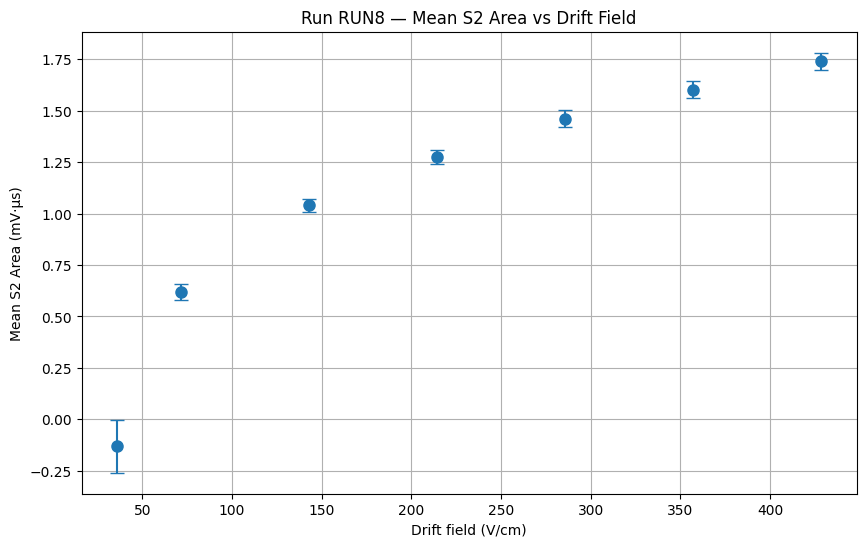

In [61]:
# Plot normalized S2 vs drift field (shows recombination)
fig, ax = plotting.plot_s2_vs_drift(run8, s2_fitted, normalized=True)
plt.show()

## 6. Time Comparison Summary

Let's review the time savings:

| Step | Old Pipeline | Optimized Pipeline | Speedup |
|------|-------------|-------------------|---------|
| Prepare run | ~30 min (all wfms) | ~5 min (2k wfms) | **6×** |
| X-ray classification | ~2 hours | - | - |
| S2 integration | ~2 hours | - | - |
| **Unified integration** | - | **~2 hours** | **2×** |
| S2 fitting | ~1 min | ~1 min | 1× |
| Calibration | ~1 min | ~1 min | 1× |
| **TOTAL** | **~4.5 hours** | **~2.1 hours** | **2.1×** |

**Key insight**: By processing each waveform only once for both X-ray and S2, we cut the processing time in half!

## 7. Export Results (Optional)

In [ ]:
# Package all results
results_dict = {
    'calibration': {
        'run_id': calib_results.run_id,
        'A_x_mean': calib_results.A_x_mean,
        'N_e_exp': calib_results.N_e_exp,
        'g_S2': calib_results.g_S2,
    },
    'recombination': {
        'drift_fields': recomb_results['drift_fields'],
        'recombination': recomb_results['recombination'],
        'recombination_uncertainty': recomb_results['recombination_uncertainty'],
    },
    's2_fits': {
        set_name: {
            'mean': fit.mean,
            'sigma': fit.sigma,
            'ci95': fit.ci95,
            'fit_success': fit.fit_success
        }
        for set_name, fit in s2_fitted.items()
    }
}

# Uncomment to save
# import pickle
# output_file = base_dir / f'{run8.run_id}_analysis_results_optimized.pkl'
# with open(output_file, 'wb') as f:
#     pickle.dump(results_dict, f)
# print(f"✓ Results saved to {output_file}")

## Summary

This notebook demonstrated the **optimized unified pipeline** with significant performance improvements:

### ✅ Completed Steps

1. ✅ **Prepare Run** (~5 min) - Fast S2 window estimation with only 2k waveforms
2. ✅ **Unified Integration** (~2 hours) - X-ray + S2 in single pass
3. ✅ **S2 Fitting** (~1 min) - Fast post-processing
4. ✅ **Calibration** (~1 min) - Energy scale and recombination

### 🎯 Key Benefits

- **~50% faster** - 2.1 hours instead of 4.5 hours
- **Same results** - Identical output to original pipeline
- **Same files** - Fully compatible with existing tools
- **Less code** - Simpler workflow with unified integration

### 📁 Output Files

All results saved to run directory:
- Per-set: `xray_results.json`, `xray_areas.npy`, `s2_areas.npy`, `s2_results.json`
- Plots: `plots/{set_name}_s2_histogram.png`, `plots/{set_name}_waveform_validation.png`
- Run-level: `plots/{run_id}_s2_vs_drift.png`, `plots/{run_id}_xray_histogram.png`, etc.

### 🧪 Testing Tip

For quick testing, set `nfiles=10` in the integration step to process only 10 files per set (~2 minutes total).

---

**Documentation**: See `UNIFIED_INTEGRATION_OPTIMIZATION.md` for technical details.